# Improvements


## Motivation

In the previous section, the RNN architecture had shortcomings which we assumed to have risen from the dataset size and class distribution.The dataset size being small, a shallow network with fewer neurons may not be able to learn the required image features too well.

## Description

In this improvement, we added 2 more RNN layers, to allow the network to learn all the required and more complex features, to yield better results.

## Architecture

![RNN Model Architecture](./images/rnn_improvement.jpg "RNN Baseline Architecture")

## Implementation

Basic outline of the implementation:
1. Environment setup
2. Model definition
3. Train and Validate functions
4. Set hyperparameters
5. Data Loading
6. Training
7. Testing
8. Evaluation

### 1. Environment Setup

In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from src.dataset import *
from src.utils import *

from einops import rearrange  

### 2. Model definition

The model architecture is as defined below:

![RNN Model Architecture](./images/rnn_baseline.jpeg "RNN Baseline Architecture")

In [3]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.layer1 = nn.RNN(self.n_inputs, self.n_neurons)
        self.layer2 = nn.RNN(self.n_neurons, self.n_neurons)
        self.layer3 = nn.RNN(self.n_neurons, self.n_neurons)
        self.layer4 = nn.Linear(self.n_neurons, self.n_outputs)

    def forward(self, X, h_init):
        # Transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2)

        g_seq , g_final = self.layer1(X , h_init)
        h_seq, h_final = self.layer2(g_seq, g_final)
        i_seq, i_final = self.layer3(h_seq, h_final)
        score_seq = self.layer4(i_final)

        return score_seq.view(-1, self.n_outputs), i_final # batch_size X n_output

### 3. Train and Validate Functions

In [4]:
def train(model, dataloader, optimizer, criterion, train_data, device):
    
    model.train()
    counter = 0
    
    running_acc = 0.0
    running_loss = 0.0
    running_error = 0.0
    
    h = torch.zeros(1, model.batch_size, model.n_neurons)
    h = h.to(device)
    
    for i, data in enumerate(dataloader):
 
        optimizer.zero_grad()
        counter += 1

        # Get image patches from the input to feed to the RNN.
        inputs, labels = data.values()
        img_patches = rearrange(
            inputs.view(model.batch_size, 3, 144, 256),
            "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
            patch_x=PATCH_SIZE,
            patch_y=PATCH_SIZE,
        )

        img_patches = img_patches.to(device)
        labels = labels.to(device)

        h = h.detach()
        h = h.requires_grad_()

        # forward + backward + optimize
        outputs, h = model(img_patches, h)
        outputs = torch.sigmoid(outputs).to(device)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().item()
        running_error += get_error(outputs.detach(), labels, model.batch_size)
        running_acc += get_accuracy(outputs.detach(), labels, model.batch_size)
        
    total_loss = running_loss / counter
    total_error = running_error / counter

    return total_loss, total_error

In [5]:
def validate(model, dataloader, criterion, val_data, device):
   
    model.eval()
    
    counter = 0
    running_loss = 0.0
    running_error = 0.0
    
    h = torch.zeros(1, model.batch_size, model.n_neurons)
    h = h.to(device)
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            
            counter += 1
            
            # Get image patches from the input to feed to the RNN.
            inputs, labels = data.values()
            img_patches = rearrange(
                inputs.view(model.batch_size, 3, 144, 256),
                "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
                patch_x=PATCH_SIZE,
                patch_y=PATCH_SIZE,
            )
            img_patches = img_patches.to(device)
            labels = labels.to(device)
            
            outputs, h = model(img_patches, h)
            
            # Apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            running_error += get_error(outputs, labels, BATCH_SIZE)
    total_loss = running_loss / counter
    total_error = running_error / counter
    return total_loss, total_error

### 4. Set hyperparameters

In [6]:
N_STEPS = 144
N_INPUTS = 768
N_NEURONS = 150
N_OUTPUTS = 6

N_EPOCHS = 20
BATCH_SIZE = 1

LR = 0.1
PATCH_SIZE = 16

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
model = model.to(device)
display_num_param(model)
print(model)
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

There are 229506 (0.23 million) parameters in this neural network
ImageRNN(
  (layer1): RNN(768, 150)
  (layer2): RNN(150, 150)
  (layer3): RNN(150, 150)
  (layer4): Linear(in_features=150, out_features=6, bias=True)
)


### 5. Data Loading

In [8]:
train_data = ImageDataset(train=True)
valid_data = ImageDataset(train=False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

Number of training images: 2065
Number of test images: 365


### 6. Training

In [9]:
train_loss = []
valid_loss = []

for epoch in range(N_EPOCHS):
    
    train_epoch_loss, train_epoch_error = train(model, train_loader, optimizer, criterion, train_data, device)
    valid_epoch_loss, valid_epoch_error = validate(model, valid_loader, criterion, valid_data, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    print(
        "Epoch:  %d | Train Loss: %.4f | Train Error: %.2f Val Loss: %.4f | Val Error: %.2f\n"
        % (epoch, train_epoch_loss, train_epoch_error, valid_epoch_loss, valid_epoch_error)
    )

Epoch:  0 | Train Loss: 0.4662 | Train Error: 20.95 Val Loss: 0.6156 | Val Error: 27.76

Epoch:  1 | Train Loss: 0.3569 | Train Error: 14.49 Val Loss: 0.6872 | Val Error: 32.15

Epoch:  2 | Train Loss: 0.3031 | Train Error: 12.03 Val Loss: 0.7357 | Val Error: 34.57

Epoch:  3 | Train Loss: 0.2623 | Train Error: 10.03 Val Loss: 0.7116 | Val Error: 27.17

Epoch:  4 | Train Loss: 0.2307 | Train Error: 8.64 Val Loss: 0.6920 | Val Error: 28.04

Epoch:  5 | Train Loss: 0.2071 | Train Error: 7.49 Val Loss: 0.7310 | Val Error: 27.12

Epoch:  6 | Train Loss: 0.1903 | Train Error: 6.81 Val Loss: 0.8739 | Val Error: 30.09

Epoch:  7 | Train Loss: 0.1698 | Train Error: 5.96 Val Loss: 0.9045 | Val Error: 31.64

Epoch:  8 | Train Loss: 0.1543 | Train Error: 5.62 Val Loss: 0.9060 | Val Error: 31.14

Epoch:  9 | Train Loss: 0.1392 | Train Error: 4.80 Val Loss: 1.0488 | Val Error: 32.42

Epoch:  10 | Train Loss: 0.1287 | Train Error: 4.58 Val Loss: 0.9787 | Val Error: 30.73

Epoch:  11 | Train Loss: 0.

### 7. Testing

In [13]:
actors = np.array(CLASSES)
print('actors: ', actors)

test_data = ImageDataset(train=False)
print(test_data[0]['image'].shape, test_data[0]['label'].shape)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']
Number of test images: 365
torch.Size([3, 144, 256]) torch.Size([6])


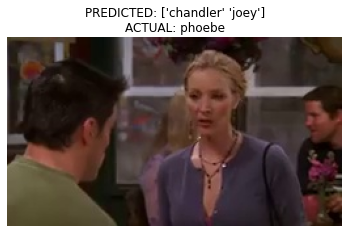

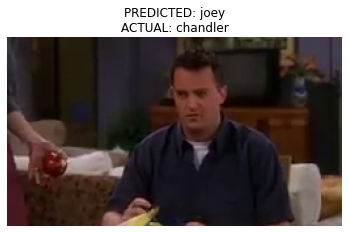

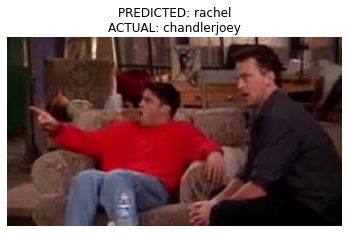

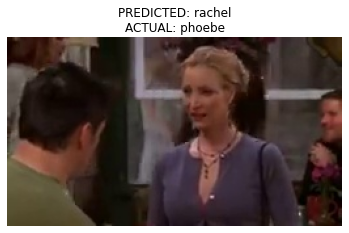

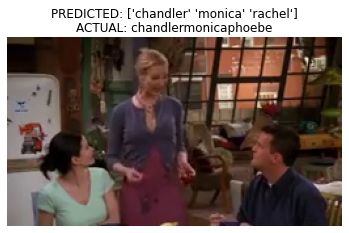

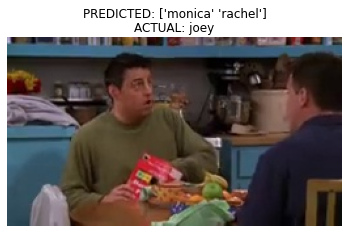

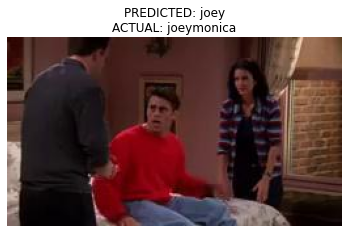

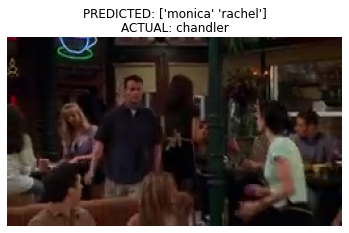

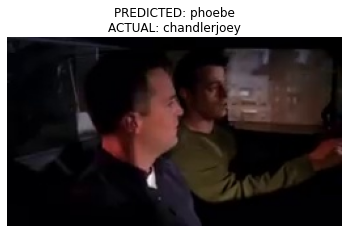

Test Error:  32.82967102969741


In [14]:
model.eval()

running_error = 0.0
running_acc = 0.0
output_list = []
target_list = []

for counter, data in enumerate(test_loader):

    h = torch.zeros(1, BATCH_SIZE, model.n_neurons)
    h = h.to(device)
    inputs, labels = data.values()
    target_indices = [i for i in range(len(labels[0])) if labels[0][i] == 1]
    img_patches = rearrange(
        inputs.view(BATCH_SIZE, 3, 144, 256),
        "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
        patch_x=PATCH_SIZE,
        patch_y=PATCH_SIZE,
    )
    img_patches = img_patches.to(device)
    labels = labels.to(device)
    h = h.detach()
    h = h.requires_grad_()

    outputs, h = model(img_patches, h)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    
    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)
    
    running_error += get_error(outputs.to(device), labels, 1)
    running_acc += get_accuracy(outputs.to(device), labels, 1)
    
    output_list.append(outputs.numpy())
    target_list.append(labels.cpu().numpy())
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}"
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}"
        
    if 10< counter < 20:
        # print(image)
        image = inputs.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = running_error / counter
print(f"Test Error: ", test_error)

out = np.array(output_list).squeeze(axis=1)
tar = np.array(target_list).squeeze(axis=1)

### 7. Evaluation

In [15]:
f1 = get_f1_score(tar, out)
precision = get_precision_score(tar, out)
recall = get_recall_score(tar, out)
print("F1 score: ", f1)
print('Precision: ', precision)
print('Recall: ', recall)

F1 score:  0.30042400521852575
Precision:  0.31666666666666665
Recall:  0.3263470319634703


C:\Users\Rishabh\anaconda3\envs\deeplearn_course\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results

For an RNN with three layers of encoding, the following are the results:

1. Training results at the end of 20 epochs:

    * Train Loss: 0.0625
    * Train Error: 2.05
    * Val Loss: 1.2632
    * Val Error: 32.79


2. Test Results:

    * Test Error:  32.83
    * F1 score:  0.3004
    * Precision:  0.3167
    * Recall:  0.3263

## Discussion

Even though increasing the number of layers, should have helped with the results we see that the test error has actually increased, along with the other metrics showing poor quality.

Possible reasons for this could be:

* **Dataset size** – RNNs require a lot more data to make better predictions.
* **Vanishing gradient problem** - In the network, when the number of layers is increased, it seems to suffer from the vanishing gradient problem. Information is lost in the network when the number of layers is increased.